In [1]:
from datetime import datetime, timedelta

from   hmmlearn.hmm import GaussianHMM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yfinance as yf

In [2]:
DATA = '../data'
TODAY = datetime.now().date()
TOMORROW  = TODAY + timedelta(1)
TOMORROW

datetime.date(2022, 12, 31)

In [3]:
sp = yf.download(
    '^GSPC', start='1965-01-01', end=str(TOMORROW)).sort_index()
nyse = yf.download(
    '^NYA', start='1965-01-01', end=str(TOMORROW)).sort_index()
nas = yf.download(
    '^IXIC', start='1965-01-01', end=str(TOMORROW)).sort_index()
wil = yf.download(
    '^W5000', start='1990-01-01', end=str(TOMORROW))

path = '../data'
sp.to_csv(f'{path}/sp1950.csv')
nyse.to_csv(f'{path}/nya1965.csv')
nas.to_csv(f'{path}/nasdaq1965.csv')
wil.to_csv(f'{path}/wilshire1990.csv')

#sp = pd.read_csv(f'{DATA}/sp1950.csv')
#nyse = pd.read_csv(f'{DATA}/nya1965.csv')
#nas = pd.read_csv(f'{DATA}/nasdaq1965.csv')
#wil = pd.read_csv(f'{DATA}/wilshire1990.csv')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [4]:
sp.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-12-23,3815.110107,3845.800049,3797.010010,3844.820068,3844.820068,2819280000
2022-12-27,3843.340088,3846.649902,3813.219971,3829.250000,3829.250000,3030300000
2022-12-28,3829.560059,3848.320068,3780.780029,3783.219971,3783.219971,3083520000
2022-12-29,3805.449951,3858.189941,3805.449951,3849.280029,3849.280029,3003680000
2022-12-30,3829.060059,3839.850098,3800.340088,3839.500000,3839.500000,1699696000


In [5]:
x = sp['Adj Close'].to_numpy()
np.append([np.nan], x[1:] / x[:-1])

array([       nan, 1.00474883, 1.00307222, ..., 0.98797936, 1.01746133,
       0.99745926])

In [6]:
def get_daily_changes(series):
    x = series.to_numpy()
    return np.append([1], x[1:] / x[:-1])

In [7]:
def prep_df(df, name):
    df.index = pd.to_datetime(df.index)
    df[f'{name}_daily'] = get_daily_changes(df['Adj Close'])
    df.rename(columns={'Adj Close': name}, inplace=True)
    return df[[name, f'{name}_daily']]

In [8]:
[sp, nyse, nas, wil] = [
    prep_df(df, name) 
    for df, name in zip(
        [sp, nyse, nas, wil], ['sp', 'nyse', 'nas', 'wil'])]
sp.head()

,sp,sp_daily
Date,,
1965-01-04,84.230003,1.000000
1965-01-05,84.629997,1.004749
1965-01-06,84.889999,1.003072
1965-01-07,85.260002,1.004359
1965-01-08,85.370003,1.001290


In [9]:
nyse.head()

,nyse,nyse_daily
Date,,
1965-12-31,528.690002,1.000000
1966-01-03,527.210022,0.997201
1966-01-04,527.840027,1.001195
1966-01-05,531.119995,1.006214
1966-01-06,532.070007,1.001789


In [10]:
nas.head()

,nas,nas_daily
Date,,
1971-02-05,100.000000,1.000000
1971-02-08,100.839996,1.008400
1971-02-09,100.760002,0.999207
1971-02-10,100.690002,0.999305
1971-02-11,101.449997,1.007548


In [11]:
def find_best_mod(daily, n_states=[6, 7, 8], max_iter=1000, reps=3):
    daily = np.reshape(daily.values, [-1, 1])
    best_logprob = -np.inf
    best_mod = None
    for states in n_states:
        for rep in range(reps):
            try:
                print(f'rep {rep + 1}', end='\r')
                for cov in ['spherical', 'diag', 'full']:
                    mod = GaussianHMM(
                        n_components=states, covariance_type=cov, n_iter=max_iter
                    ).fit(daily)
                    logprob = mod.score(daily)
                    if logprob > best_logprob:
                        print(f'New best - States: {states} (cov: {cov})')
                        best_logprob = logprob
                        best_mod = mod
            except ValueError:
                pass
    return best_mod

In [12]:
def get_preds(daily, mod):
    daily = np.reshape(daily.values, [-1, 1])
    states = mod.predict(daily)
    means = np.squeeze(mod.means_)
    sds = np.squeeze(np.sqrt(mod.covars_))
    preds = np.array([means[state] for state in states])
    ses = np.array([1.96 * sds[state] for state in states])
    return preds, ses, means, states[-1]

In [13]:
def plot_mod(df, preds, ses, name):
    daily = f'{name}_daily'
    plt.plot(df[daily], label='daily')
    plt.plot(df.index, preds, label='preds')
    plt.legend()

    plt.figure()
    plt.plot(df[daily], label='daily')
    plt.axhline(y=1, color='k')
    plt.plot(
        df.index, preds, label='preds', color='orange', linewidth=3)
    plt.plot(df.index, preds + ses, color='orange', linestyle='-.')
    plt.plot(df.index, preds - ses, color='orange', linestyle='-.')
    plt.ylim([0.95, 1.05]);
    plt.xlim([df.index[-500], df.index[-1]])

    plt.figure()
    plt.plot(df[name])
    plt.xlim([df.index[-500], df.index[-1]])
    sub = df.iloc[-500:, :]
    plt.ylim(
        0.95 * sub[name].min(), 1.05 * sub[name].max());

In [14]:
def get_expected_val(mod, current_state, means):
    return np.dot(mod.transmat_[current_state, :], means)

## S&P

New best - States: 3 (cov: spherical)
New best - States: 3 (cov: diag)
New best - States: 4 (cov: spherical)
New best - States: 4 (cov: diag)
New best - States: 4 (cov: full)
New best - States: 4 (cov: spherical)
New best - States: 4 (cov: spherical)
0.999949145718251


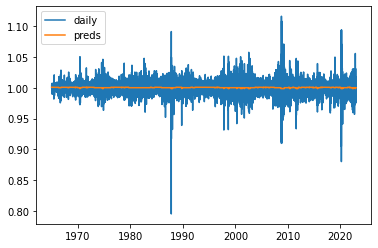

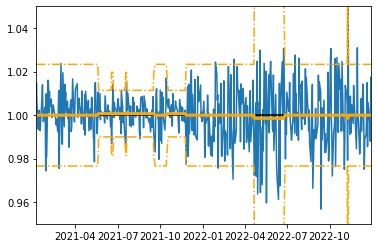

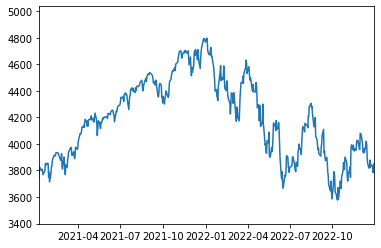

In [15]:
sp_mod = find_best_mod(sp.sp_daily, n_states=[3, 4, 5, 6])
sp_preds, sp_ses, sp_means, sp_current = get_preds(sp.sp_daily, sp_mod)
plot_mod(sp, sp_preds, sp_ses, 'sp')
sp_exp = get_expected_val(sp_mod, sp_current, sp_means)
print(sp_exp)

## NYSE

New best - States: 5 (cov: spherical)
New best - States: 6 (cov: spherical)
New best - States: 6 (cov: full)
New best - States: 6 (cov: diag)
New best - States: 7 (cov: spherical)
New best - States: 7 (cov: diag)
New best - States: 7 (cov: spherical)
1.0000409055032797


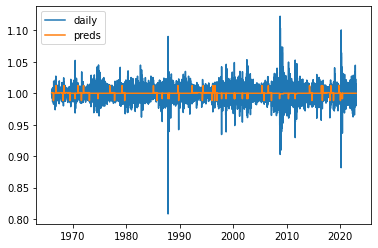

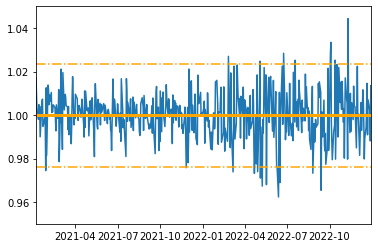

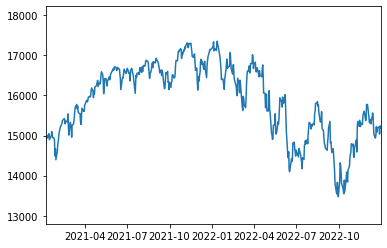

In [16]:
nyse_mod = find_best_mod(nyse.nyse_daily, n_states=[5, 6, 7, 8])
nyse_preds, nyse_ses, nyse_means, nyse_current = get_preds(
    nyse.nyse_daily, nyse_mod)
plot_mod(nyse, nyse_preds, nyse_ses, 'nyse')
nyse_exp = get_expected_val(nyse_mod, nyse_current, nyse_means)
print(nyse_exp)

## Nasdaq

New best - States: 8 (cov: spherical)
New best - States: 8 (cov: diag)


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/hmmlearn/hmm.py:272: RuntimeWarning: invalid value encountered in divide
  self.means_ = ((means_weight * means_prior + stats['obs'])


New best - States: 9 (cov: spherical)


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/hmmlearn/hmm.py:272: RuntimeWarning: invalid value encountered in divide
  self.means_ = ((means_weight * means_prior + stats['obs'])


New best - States: 9 (cov: spherical)


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/hmmlearn/hmm.py:272: RuntimeWarning: invalid value encountered in divide
  self.means_ = ((means_weight * means_prior + stats['obs'])


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/hmmlearn/hmm.py:272: RuntimeWarning: invalid value encountered in divide
  self.means_ = ((means_weight * means_prior + stats['obs'])


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/hmmlearn/hmm.py:272: RuntimeWarning: invalid value encountered in divide
  self.means_ = ((means_weight * means_prior + stats['obs'])


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/hmmlearn/hmm.py:272: RuntimeWarning: invalid value encountered in divide
  self.means_ = ((means_weight * means_prior + stats['obs'])


1.000406989268937


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/hmmlearn/hmm.py:272: RuntimeWarning: invalid value encountered in divide
  self.means_ = ((means_weight * means_prior + stats['obs'])


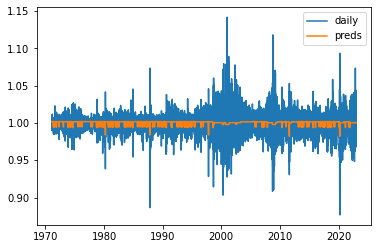

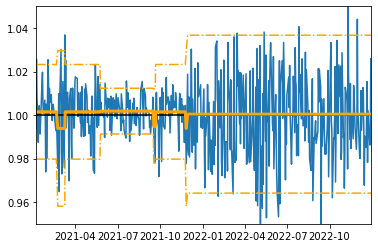

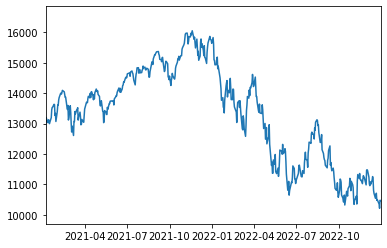

In [17]:
nas_mod = find_best_mod(nas.nas_daily, n_states=[8, 9, 10])
nas_preds, nas_ses, nas_means, nas_current = get_preds(
    nas.nas_daily, nas_mod)
plot_mod(nas, nas_preds, nas_ses, 'nas')
nas_exp = get_expected_val(nas_mod, nas_current, nas_means)
print(nas_exp)

## Wilshire

New best - States: 7 (cov: spherical)


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/hmmlearn/hmm.py:272: RuntimeWarning: invalid value encountered in divide
  self.means_ = ((means_weight * means_prior + stats['obs'])


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/hmmlearn/hmm.py:272: RuntimeWarning: invalid value encountered in divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/hmmlearn/hmm.py:272: RuntimeWarning: invalid value encountered in divide
  self.means_ = ((means_weight * means_prior + stats['obs'])


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/hmmlearn/hmm.py:306: RuntimeWarning: overflow encountered in divide
  self._covars_ = ((covars_prior + c_n) /


New best - States: 9 (cov: diag)


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/hmmlearn/hmm.py:272: RuntimeWarning: invalid value encountered in divide
  self.means_ = ((means_weight * means_prior + stats['obs'])


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/hmmlearn/hmm.py:272: RuntimeWarning: invalid value encountered in divide
  self.means_ = ((means_weight * means_prior + stats['obs'])


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/hmmlearn/hmm.py:272: RuntimeWarning: invalid value encountered in divide
  self.means_ = ((means_weight * means_prior + stats['obs'])


1.0003832394901906


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/hmmlearn/hmm.py:272: RuntimeWarning: invalid value encountered in divide
  self.means_ = ((means_weight * means_prior + stats['obs'])


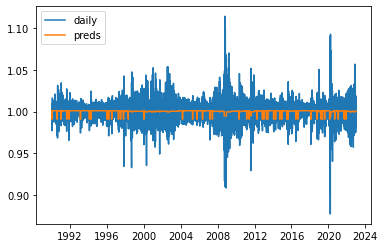

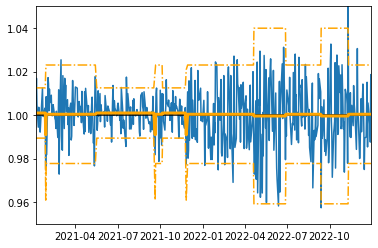

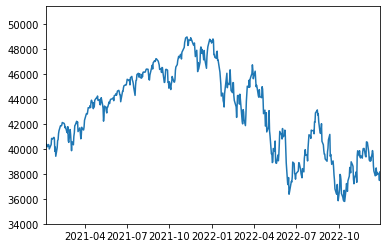

In [18]:
wil_mod = find_best_mod(wil.wil_daily, n_states=[7, 8, 9, 10])
wil_preds, wil_ses, wil_means, wil_current = get_preds(
    wil.wil_daily, wil_mod)
plot_mod(wil, wil_preds, wil_ses, 'wil')
wil_exp = get_expected_val(wil_mod, wil_current, wil_means)
print(wil_exp)

In [19]:
mean_states = (4 + 7 + 9 + 9) / 4
mean_states

7.25

In [110]:
N_STATES = int(round(mean_states))
N_STATES

7

In [111]:
exp = (sp_exp + nyse_exp + nas_exp + wil_exp) / 4
exp

1.0001950699951645

In [112]:
for df, name, exp in zip(
        [sp, nyse, nas, wil],
        ['sp', 'nyse', 'nas', 'wil'],
        [sp_preds, nyse_preds, nas_preds, wil_preds]):
    df[f'{name}_exp'] = exp

/var/folders/41/jhvt_zmd3nz3x5jsqblr221r0000gn/T/ipykernel_73438/3186342578.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'{name}_exp'] = exp


In [113]:
df = pd.concat([sp, nyse, nas, wil], axis=1)
df.tail()

,sp,sp_daily,sp_exp,nyse,nyse_daily,nyse_exp,nas,nas_daily,nas_exp,wil,wil_daily,wil_exp
Date,,,,,,,,,,,,
2022-12-23,3844.820068,1.005868,0.999948,15188.450195,1.007089,0.999867,10497.860352,1.002075,1.000419,38110.421875,1.005559,1.000378
2022-12-27,3829.250000,0.995950,0.999948,15218.259766,1.001963,0.999867,10353.230469,0.986223,1.000419,37931.738281,0.995311,1.000378
2022-12-28,3783.219971,0.987979,0.999948,15037.320312,0.988110,0.999867,10213.290039,0.986483,1.000419,37460.910156,0.987587,1.000378
2022-12-29,3849.280029,1.017461,0.999948,15241.209961,1.013559,0.999867,10478.089844,1.025927,1.000419,38159.328125,1.018644,1.000378
2022-12-30,3839.500000,0.997459,0.999948,15184.309570,0.996267,0.999867,10466.481445,0.998892,1.000419,38073.937500,0.997762,1.000378


In [114]:
df['mean_exp'] = (
    df[['sp_exp', 'nyse_exp', 'nas_exp', 'wil_exp']].mean(axis=1))

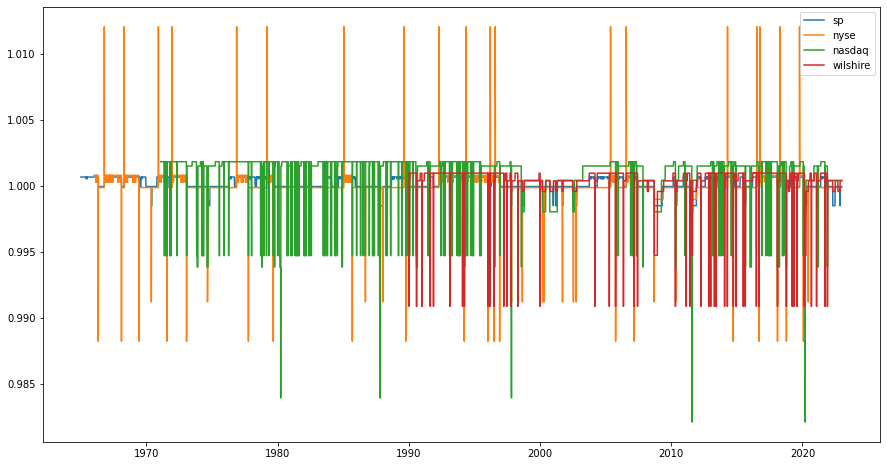

In [115]:
plt.figure(figsize=[15, 8])
plt.plot(df.sp_exp, label='sp')
plt.plot(df.nyse_exp, label='nyse')
plt.plot(df.nas_exp, label='nasdaq')
plt.plot(df.wil_exp, label='wilshire')

plt.legend();

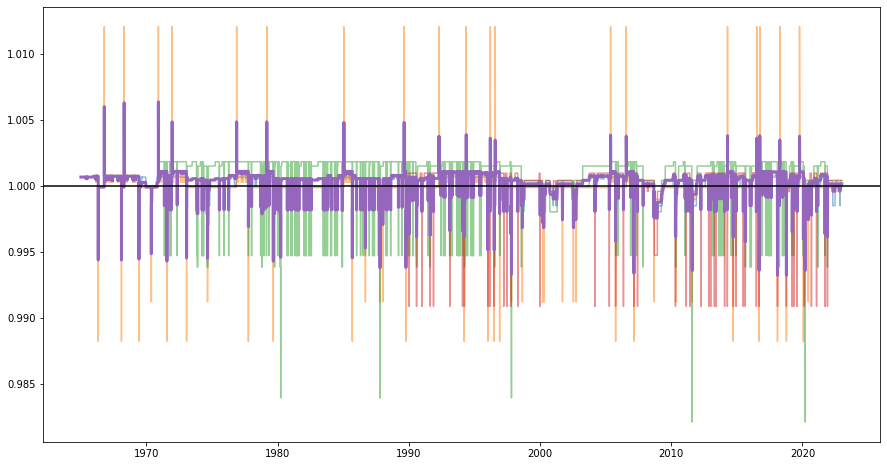

In [116]:
plt.figure(figsize=[15, 8])
plt.plot(df.sp_exp, alpha=0.5)
plt.plot(df.nyse_exp, alpha=0.5)
plt.plot(df.nas_exp, alpha=0.5)
plt.plot(df.wil_exp, alpha=0.5)
plt.plot(df.mean_exp, linewidth=3)
plt.axhline(y=1, color='k');

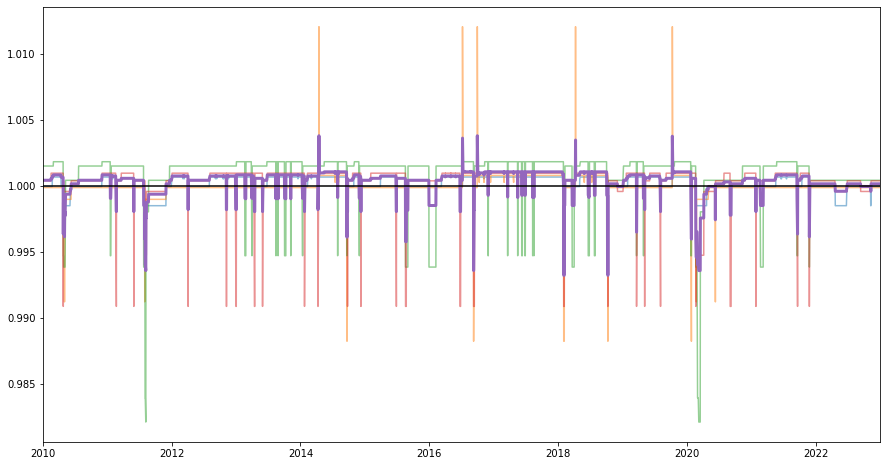

In [117]:
TODAY = datetime.now()
plt.figure(figsize=[15, 8])
plt.plot(df.sp_exp, alpha=0.5)
plt.plot(df.nyse_exp, alpha=0.5)
plt.plot(df.nas_exp, alpha=0.5)
plt.plot(df.wil_exp, alpha=0.5)
plt.plot(df.mean_exp, linewidth=3)
plt.axhline(y=1, color='k')
plt.xlim(pd.to_datetime('2010-01-01'), TODAY);

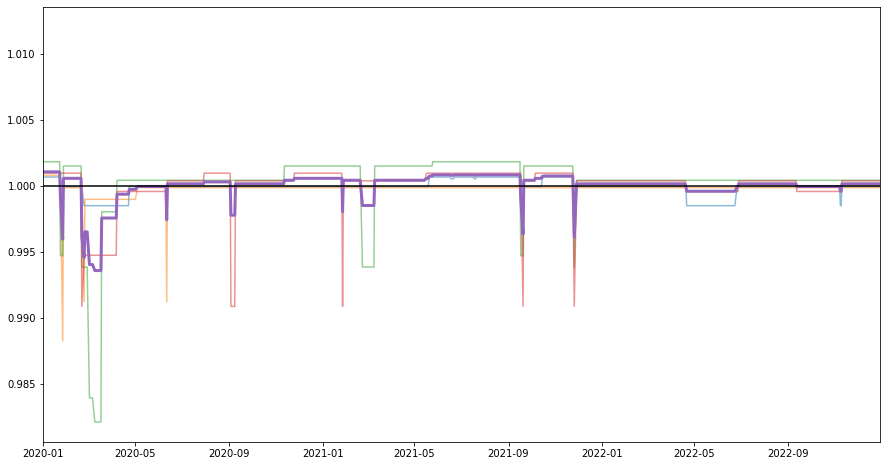

In [118]:
TODAY = datetime.now()
plt.figure(figsize=[15, 8])
plt.plot(df.sp_exp, alpha=0.5)
plt.plot(df.nyse_exp, alpha=0.5)
plt.plot(df.nas_exp, alpha=0.5)
plt.plot(df.wil_exp, alpha=0.5)
plt.plot(df.mean_exp, linewidth=3)
plt.xlim(pd.to_datetime('2020-01-01'), TODAY);
plt.axhline(y = 1, color='k');

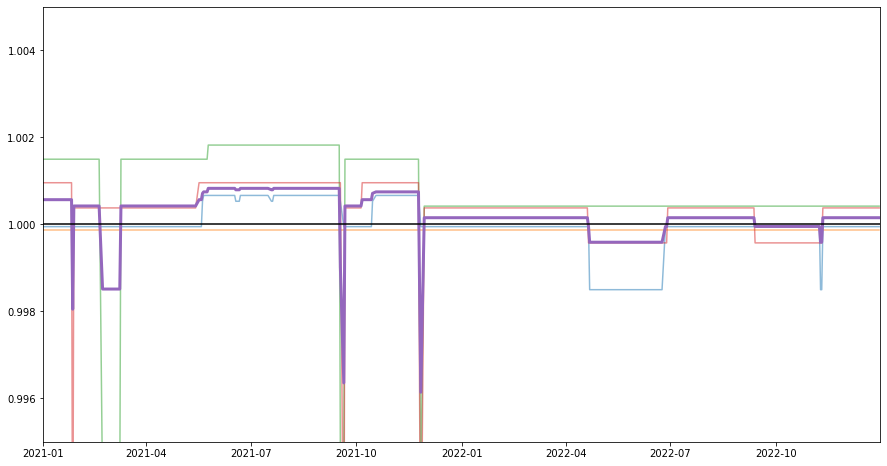

In [119]:
plt.figure(figsize=[15, 8])
plt.plot(df.sp_exp, alpha=0.5)
plt.plot(df.nyse_exp, alpha=0.5)
plt.plot(df.nas_exp, alpha=0.5)
plt.plot(df.wil_exp, alpha=0.5)
plt.plot(df.mean_exp, linewidth=3)
plt.axhline(y=1, color='k')
plt.xlim(pd.to_datetime('2021-01-01'), TODAY)
plt.ylim([0.995, 1.005]);


In [120]:
df = df[df.index >= pd.to_datetime('1970-01-01')]

In [121]:
try:
    df['state'] = pd.qcut(
        df.mean_exp,
        N_STATES,
        retbins=False,
        duplicates='drop',
        labels=range(N_STATES))
except ValueError:
    df['state'] = pd.qcut(
        df.mean_exp,
        N_STATES,
        retbins=False,
        duplicates='drop',
        labels=range(N_STATES - 1))

In [122]:
df.state.value_counts()

0    3228
2    2519
5    2416
4    2146
1    1476
6     912
3     672
Name: state, dtype: int64

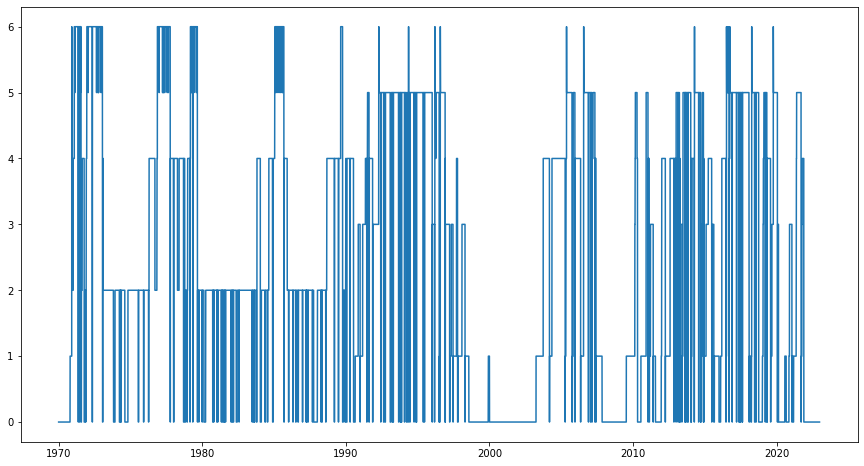

In [123]:
plt.figure(figsize=[15, 8])
plt.plot(df.state);

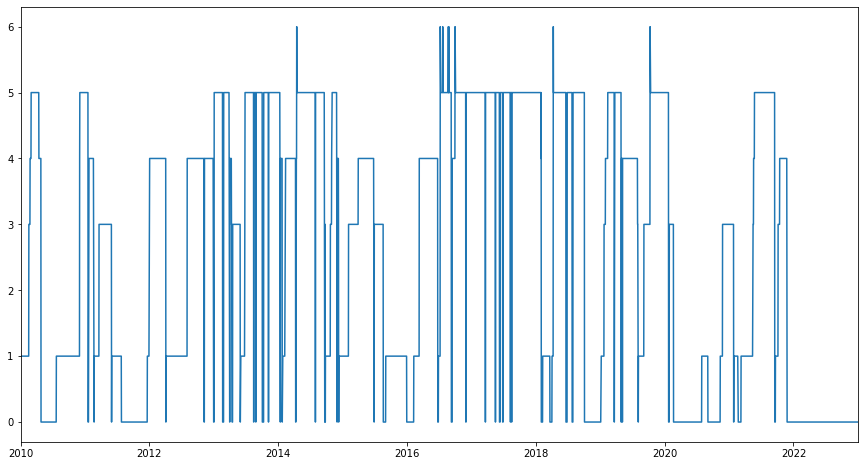

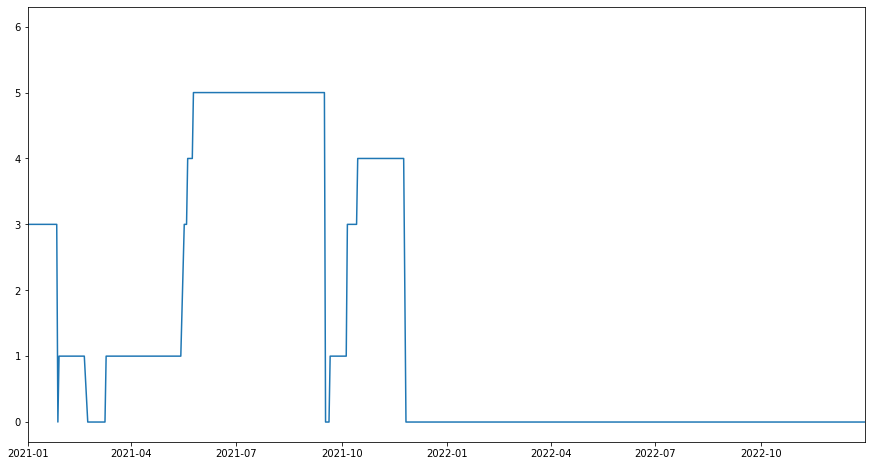

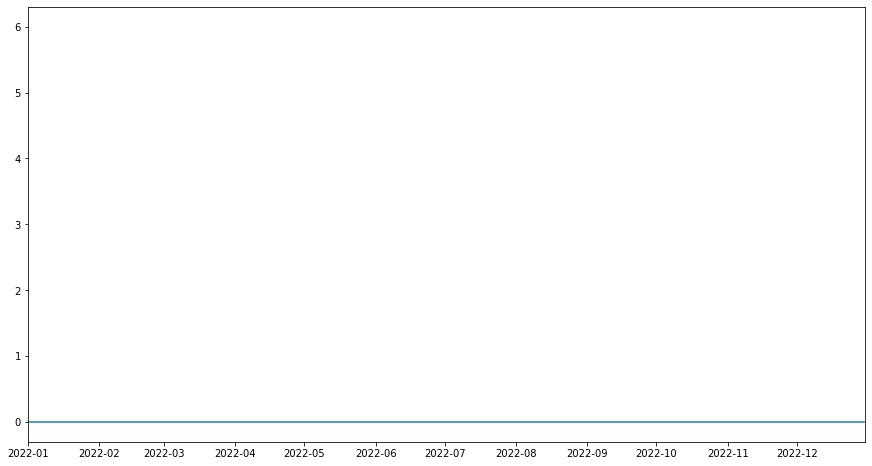

In [124]:
plt.figure(figsize=[15, 8])
plt.plot(df.state)
plt.xlim(pd.to_datetime('2010-01-01'), TODAY);

plt.figure(figsize=[15, 8])
plt.plot(df.state)
plt.xlim(pd.to_datetime('2021-01-01'), TODAY);

plt.figure(figsize=[15, 8])
plt.plot(df.state)
plt.xlim(pd.to_datetime('2022-01-01'), TODAY);

In [125]:
df.to_csv(f'{DATA}/hmm_exp_returns.csv')

In [126]:
TODAY

datetime.datetime(2022, 12, 30, 13, 55, 2, 703494)

In [127]:
df.state[-1]

0

In [128]:
df.state.value_counts()

0    3228
2    2519
5    2416
4    2146
1    1476
6     912
3     672
Name: state, dtype: int64

In [129]:
state_var = (
    df[['state', 'mean_exp']].groupby('state').agg(['mean', 'std']))
state_var.columns = ['mean', 'std']
state_var
state_var['ci'] = state_var.apply(
    lambda row: [
        row['mean'] - 1.96*row['std'],
        row['mean'] + 1.96*row['std']], axis=1)
state_var

,mean,std,ci
state,,,
0,0.999395,0.001083,"[0.9972723921293951, 1.0015177042656231]"
1,1.000415,0.000032,"[1.0003518539771228, 1.0004785560345077]"
2,1.000519,0.000047,"[1.0004263367744957, 1.0006109151133387]"
3,1.000568,0.000000,"[1.0005675818238875, 1.0005675818238875]"
4,1.000748,0.000044,"[1.0006627440971532, 1.000834006060418]"
5,1.000990,0.000095,"[1.0008027873517304, 1.0011771188771867]"
6,1.001150,0.000431,"[1.0003048224051578, 1.0019942731435154]"


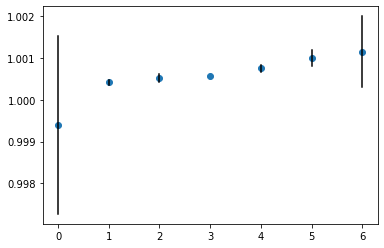

In [135]:
plt.scatter(state_var.index, state_var['mean'])
for state in range(N_STATES):
    plt.plot([state, state], state_var.loc[state, 'ci'], color='k');